### **1. Cài đặt môi trường và cài thư viện cần thiết**

In [ ]:
# Cài đặt thư viện cần thiết
# !pip install -q tensorflow
# !pip install tf2onnx

### **2. Import thư viện**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import pickle
import os
import pandas as pd
import random
from google.colab import files, drive
import tensorflow as tf
import tf2onnx
import onnx

### **3. Thiết lập tham số**

In [ ]:
batch_size_val = 50
steps_per_epoch_val = 2000
epochs_val = 10
imageDimesions = (32, 32, 3)
testRatio = 0.2
validationRatio = 0.2

### **4. Upload dữ liệu lên Colab**

In [ ]:
drive.mount('/content/drive')
path = "/content/drive/MyDrive/myData"
labelFile = "/content/drive/MyDrive/labels.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **5. Đọc và lưu trữ dữ liệu**

In [ ]:
count = 0
images = []
classNo = []
myList = os.listdir(path)
noOfClasses = len(myList)
print("Total Classes Detected:", noOfClasses)
print("Importing Classes.....")
for x in range(noOfClasses):
    myPicList = os.listdir(os.path.join(path, str(count)))
    for y in myPicList:
        curImg = cv2.imread(os.path.join(path, str(count), y))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Total Classes Detected: 43
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42  


### **6. Chia dữ liệu**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# Kiểm tra kích thước dữ liệu
print("Data Shapes")
print("Train", X_train.shape, y_train.shape)
print("Validation", X_validation.shape, y_validation.shape)
print("Test", X_test.shape, y_test.shape)

Data Shapes
Train (22271, 32, 32, 3) (22271,)
Validation (5568, 32, 32, 3) (5568,)
Test (6960, 32, 32, 3) (6960,)


### **7. Đọc file nhãn (labels.csv)**

In [ ]:
data = pd.read_csv(labelFile)
print("Data Shape:", data.shape)

Data Shape: (43, 2)


### **8. Hiển thị mẫu ảnh**

In [ ]:
num_of_samples = []
cols = 5
num_classes = noOfClasses

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected)-1), :, :])
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(f"{j} - {row['Name']}")
            num_of_samples.append(len(x_selected))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **9. Biểu đồ phân bố dữ liệu**

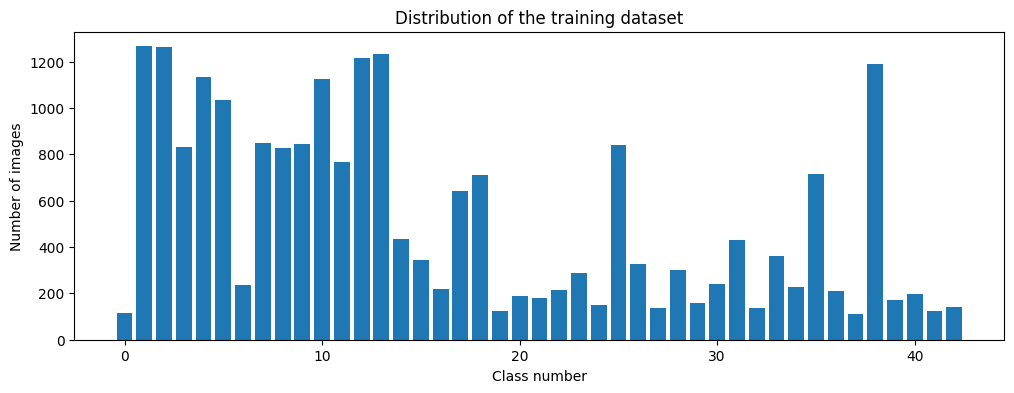

In [ ]:
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

### **10. Tiền xử lý ảnh**

In [ ]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def equalize(img):
    return cv2.equalizeHist(img)

def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

# Thêm chiều kênh (channel)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

### **11. Data Augmentation**

In [ ]:
dataGen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)
dataGen.fit(X_train)

### **12. One-hot encoding**

In [ ]:
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

### **13. Định nghĩa mô hình CNN**

In [ ]:
def myModel():
    model = Sequential()
    model.add(Conv2D(60, (5,5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(Conv2D(30, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))

    model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = myModel()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


### **14. Train mô hình**

In [ ]:
history = model.fit(
    dataGen.flow(X_train, y_train, batch_size=batch_size_val),
    steps_per_epoch=steps_per_epoch_val,
    epochs=epochs_val,
    validation_data=(X_validation, y_validation),
    shuffle=True
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 446/2000 ━━━━━━━━━━━━━━━━━━━━ 11:39 450ms/step - accuracy: 0.1459 - loss: 3.1786

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 224s 111ms/step - accuracy: 0.2447 - loss: 2.7339 - val_accuracy: 0.7396 - val_loss: 0.9534
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 211s 105ms/step - accuracy: 0.5961 - loss: 1.3180 - val_accuracy: 0.9080 - val_loss: 0.3849
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 255s 102ms/step - accuracy: 0.7298 - loss: 0.8661 - val_accuracy: 0.9391 - val_loss: 0.2075
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 268s 105ms/step - accuracy: 0.7991 - loss: 0.6456 - val_accuracy: 0.9673 - val_loss: 0.1349
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 211s 105ms/step - accuracy: 0.8372 - loss: 0.5195 - val_accuracy: 0.9749 - val_loss: 0.1016
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 203s 102ms/step - accuracy: 0.8598 - loss: 0.4457 - val_accuracy: 0.9754 - val_loss: 0.0862
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 263s 102ms/step - accuracy: 0.8739 - loss: 0.4047 - val_accuracy: 0.9675 - val_loss: 0.1006
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 213s 106ms/step - accuracy: 0.8

### **15. Vẽ đồ thị training**

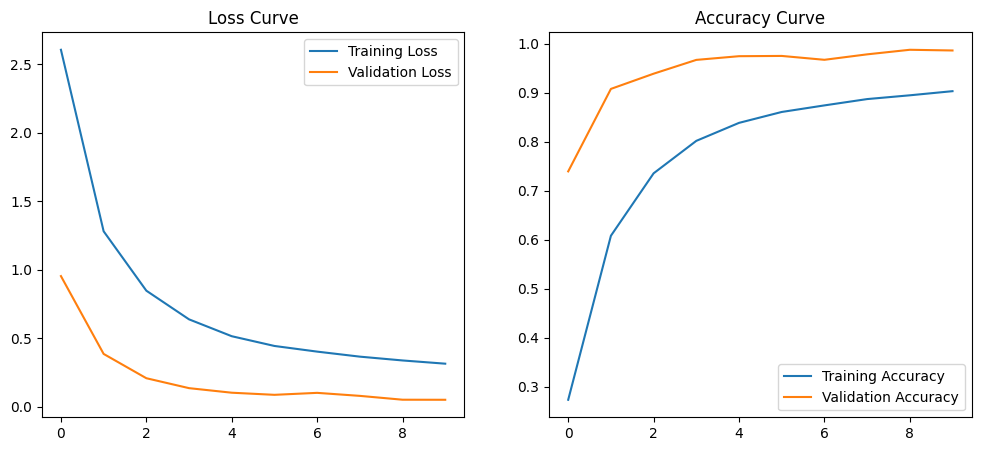

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

### **16. Đánh giá mô hình**

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 0.05062665045261383
Test Accuracy: 0.9852011203765869


### **17. Lưu mô hình**

In [ ]:
model.save("model_keras.h5")
# files.download("model_keras.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Chuyển thành file onnx và lưu về máy**

In [ ]:
seq_model = tf.keras.models.load_model("model_keras.h5")

inputs = tf.keras.Input(shape=(32, 32, 1), name="input")
outputs = seq_model(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

spec = (tf.TensorSpec((None, 32, 32, 1), tf.float32, name="input"),)
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

files.download("model.onnx")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7a1b9ed65a80>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>